# Practice EfficentNet with bad-guy classification datasets

Link to paper: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
](https://arxiv.org/pdf/1905.11946.pdf)

## 1. Download dataset

In [ ]:
# !kaggle datasets download -d gpiosenka/good-guysbad-guys-image-data-set
# !mkdir data
# %cd data
# !unzip good-guysbad-guys-image-data-set.zip

## 2. Preparing module in need

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pandas as pd


import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F

from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 3. Analyst dataset

In [15]:
DATASET_FOLDER = "./data"
TRAIN_FOLDER = f"{DATASET_FOLDER}/train"
TEST_FOLDER = f"{DATASET_FOLDER}/test"
VALID_FOLDER = f"{DATASET_FOLDER}/valid"

INFO_CHARACTER = f"{DATASET_FOLDER}/character.csv"
INFO_CLASS = f"{DATASET_FOLDER}/class_dict.csv"

In [16]:
character_df = pd.read_csv(INFO_CHARACTER)

character_df

,class index,filepaths,labels,data set
0,0,train/savory/0001.jpg,savory,train
1,0,train/savory/0002.jpg,savory,train
2,0,train/savory/0003.jpg,savory,train
3,0,train/savory/0004.jpg,savory,train
4,0,train/savory/0005.jpg,savory,train
...,...,...,...,...
12415,1,valid/unsavory/296.jpg,unsavory,valid
12416,1,valid/unsavory/297.jpg,unsavory,valid
12417,1,valid/unsavory/298.jpg,unsavory,valid
12418,1,valid/unsavory/299.jpg,unsavory,valid


In [12]:
character_df["class index"].value_counts()

0    6210
1    6210
Name: class index, dtype: int64

In [17]:
character_df["data set"].value_counts()

train    11220
test       600
valid      600
Name: data set, dtype: int64

In [18]:
class_df = pd.read_csv(INFO_CLASS)

class_df

,class_index,class,height,width,scale by,Offset
0,0,savory,300,233,1,0
1,1,unsavory,300,233,1,0


In [59]:
class BadGuyDataset(Dataset):
    def __init__(self, csv_file, root_dir, type = "train", transform = None):
        """_summary_

        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Directory with all the images
            type (string): The type of dataset: train, test or valid
            transform (callable, optional): Optional transform to be applied
                on a sample. Defaults to None.
        """
        self.type = type
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file).groupby("data set").get_group(type)
        
        self.data = np.array([
            io.imread(os.path.join(root_dir,img['filepaths']))
            for img in self.df.iloc
        ])
        self.targets = np.array([
            img['class index']
            for img in self.df.iloc
        ])
        
        self.classes = np.array(class_df['class'])
        
        
        print(f"Found {len(self.df)} data of type {type}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            ids = idx.tolist()
        
        images = self.data[idx]
        labels = self.targets[idx]
        
        if self.transform:
            images = self.transform(images)
        return images, labels   

## Hyperparameters


In [60]:
batch_size = 64
epochs = 100


# Import data

In [72]:
imageTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), interpolation=InterpolationMode.BICUBIC)
])

train_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="train", transform=imageTransform)
test_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="test", transform=imageTransform)
valid_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="valid", transform=imageTransform)

train_loader = DataLoader(
    dataset=train_dataset,
    drop_last=True,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

Found 11220 data of type train
Found 600 data of type test
Found 600 data of type valid


## Visualize example Data

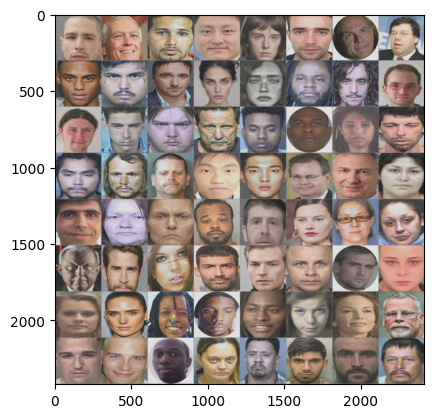

In [80]:
classes = ("BAD GUY", "GOOD GUY")

samples = iter(train_loader)

images, labels = samples.__next__()

imgs = torchvision.utils.make_grid(images, normalize=True, pad_value=0.5)

imgs = imgs.numpy()
imgs = imgs.transpose((1, 2, 0))

plt.imshow(imgs)
plt.show()




## Preparing Custom EfficentNet Model

In [ ]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3]
] 

phi_values = {
    # tuple of : (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2), #alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    pass

class SqueezeExcitation(nn.Module):
    pass

class InvertedResidualBlock(nn.Module):
    pass

class EfficientNet(nn.Module):
    pass